<a href="https://colab.research.google.com/github/NadiaHolmlund/Semester_Project/blob/main/ver_4_Facial_Emotion_Recognition_(FER).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Emotion Recognition (FER)

The following notebook contains the fine-tuning process of pre-trained vision models on the [FER2013](https://www.kaggle.com/datasets/deadskull7/fer2013) dataset. The dataset is a collection of 35.887 48x48 grayscale images of faces divided into 7 classes (Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral). The training set consists of 28.709 images while the validation and test sets consist of 3.589 images, respectively.

The vision models applied during the training process includes [ViT](https://huggingface.co/docs/transformers/model_doc/vit) from Google, [ResNet](https://huggingface.co/docs/transformers/model_doc/resnet) from Microsoft and [ConvNeXT](https://huggingface.co/docs/transformers/model_doc/convnext) from Facebook.

Please be aware that the notebook includes code for all three models in the sections: ***Defining the processor*** and ***Defining the model***. Therefore, if running the code, do only run the processor and model corresponding to the one you wish to train.

In the notebook, the data is prepared using 🤗 [datasets](https://github.com/huggingface/datasets) and the models are trained using the 🤗 [Trainer](https://huggingface.co/transformers/main_classes/trainer.html).

The process is inspired by a tutorial by Niels Rogge, ML engineer at 🤗 [HuggingFace](https://huggingface.co'), who fine-tuned ViT on the CIFAR-10 dataset using the 🤗 [Trainer](https://huggingface.co/transformers/main_classes/trainer.html). The tutorial can be found [here](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/VisionTransformer).

# Imports

In [1]:
# Pip installs
!pip install -q transformers==4.28.0 # Installing version 4.28.0 to circumvent an issue with Accelerator and the introduction of PartialState in later versions
!pip install -q transformers datasets
!pip install -q mlflow
!pip install -q pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:

# Libraries
from datasets import *
from transformers import ViTImageProcessor, ViTConfig, ViTModel
from transformers import AutoImageProcessor, ResNetConfig, ResNetModel
from transformers import ConvNextImageProcessor, ConvNextConfig, ConvNextModel
from transformers import PreTrainedModel
from transformers import TrainingArguments, Trainer
from transformers.modeling_outputs import SequenceClassifierOutput
import numpy as np
import pandas as pd 
import torch.nn as nn
import pickle
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.metrics import confusion_matrix
import mlflow
from pyngrok import ngrok
from getpass import getpass

# Connecting to Google Drive

Due to the size of the dataset (301MB) it exceeds the file-size limit on Github, hence it is loaded from Google Drive (requires folder access).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Semester_Project

/content/gdrive/MyDrive/Semester_Project


# Setting up MLflow for experiment tracking

## Setting up MLflow UI

In [ ]:
# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &")

# Terminate open tunnels if any exist
ngrok.kill()

In [ ]:
import os

google_drive_path = "/content/gdrive/MyDrive/Semester_Project/mlruns"
mlflow_tracking_uri = f"file://{google_drive_path}"

os.environ["MLFLOW_TRACKING_URI"] = mlflow_tracking_uri

In [ ]:
# Login on ngrok.com and get your authtoken from https://dashboard.ngrok.com/auth
# Enter your auth token when the code is running
NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

Enter the ngrok authtoken: ··········


MLflow Tracking UI: https://6164-34-91-191-89.ngrok-free.app


## Setting up new experiments and/or new runs
Note: Only run this section if setting up a new experiment

In [ ]:
experiment_name = "saving_strategy_mlruns"
run_name = "fuxking_one_more"

In [ ]:
# Only run this code if creating a whole new experiment (not just a new run)
#mlflow.create_experiment(experiment_name)

In [ ]:
# Get the experiment ID for the experiment with the specified name
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

In [ ]:
## Starting MLflow, running UI in background
mlflow.start_run(run_name=run_name, nested=True, experiment_id=experiment_id)

<ActiveRun: >

# Loading the data



In [ ]:
fer_df = pd.read_csv("/content/gdrive/MyDrive/Semester_Project/FER2013.csv")  # available on kaggle

In [ ]:
fer_df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
fer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


# Defining the processor

## ViT Processor

In [ ]:
# The image processor resizes every image to the resolution that the model expects, i.e. 224x224, and normalizes the channels
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

## ResNet Processor

In [ ]:
# The image processor resizes every image to the resolution that the model expects, i.e. 224x224, and normalizes the channels
processor = AutoImageProcessor.from_pretrained('microsoft/resnet-18')

## ConvNet processor

In [ ]:
# The image processor resizes every image to the resolution that the model expects, i.e. 224x224, and normalizes the channels
processor = ConvNextImageProcessor.from_pretrained('facebook/convnext-base-224')

# Preprocessing the data

In [ ]:
# Defining the labels for emotions in the dataset
string_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

In [ ]:
# Creating a dictionary connecting the emotion_id and emotion_label
emotion_id = np.sort(fer_df['emotion'].unique())
emotion_label = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

id2label = {id: label for id, label in zip(emotion_id, emotion_label)}
label2id = {label: id for id, label in id2label.items()}

First preprocessing step

In [ ]:
def prepare_fer_data(data):
    """ Prepare fer data for vision transformer 
        input: fer df loaded from csv
        output: df that can be load into a huggingface dataset """

    # outputs
    image_list = []
    image_labels = list(map(int, data['emotion']))
    
    # go over all images
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        # adapt grayscale to rgb format (change single values to triplets of the same value)
        image = image[..., np.newaxis]
        image = np.repeat(image, 3, axis=2)
        # convert to list format used by the later functions
        image = image.astype(int).tolist()
        # save to output
        image_list.append(image)

    output_df = pd.DataFrame(list(zip(image_list, image_labels)),
               columns =['img', 'label'])
        
    return output_df

In [ ]:
fer_train_df = prepare_fer_data(fer_df[fer_df['Usage']=='Training'].sample(n = 50))
fer_test_df = prepare_fer_data(fer_df[fer_df['Usage']=='PrivateTest'].sample(n = 5))
fer_val_df = prepare_fer_data(fer_df[fer_df['Usage']=='PublicTest'].sample(n = 5))

In [ ]:
fer_train_df.head()

,img,label
0,"[[[70, 70, 70], [80, 80, 80], [82, 82, 82], [7...",0
1,"[[[151, 151, 151], [150, 150, 150], [147, 147,...",0
2,"[[[231, 231, 231], [212, 212, 212], [156, 156,...",2
3,"[[[24, 24, 24], [32, 32, 32], [36, 36, 36], [3...",4
4,"[[[4, 4, 4], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",6


In [ ]:
train_ds = Dataset.from_pandas(fer_train_df)
val_ds = Dataset.from_pandas(fer_val_df)
test_ds = Dataset.from_pandas(fer_test_df)

print(train_ds)
print(val_ds)
print(test_ds)

Dataset({
    features: ['img', 'label'],
    num_rows: 28709
})
Dataset({
    features: ['img', 'label'],
    num_rows: 3589
})
Dataset({
    features: ['img', 'label'],
    num_rows: 3589
})


In [ ]:
# image size 
np.array(train_ds[0]["img"]).shape

(48, 48, 3)

Second preprocessing step using the image processors

In [ ]:
def preprocess_images(examples):
    """ Prepare datasets for vision transformer 
    input: dataset with images in their orignal size 
    output: dataset with pixelvalues computed by the feature extractor added """
    # get batch of images
    images = examples['img']
    # convert to list of NumPy arrays of shape (C, H, W)
    images = [np.array(image, dtype=np.uint8) for image in images]
    images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    # preprocess and add pixel_values
    inputs = processor(images=images)
    examples['pixel_values'] = inputs['pixel_values']

    return examples

In [ ]:
# features of the new dataset with an additional column for the preprocess 224x224x3 images 
features = Features({
    'label': ClassLabel(names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']),
    'img': Array3D(dtype="int64", shape=(3,48,48)),
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
})

preprocessed_train_ds = train_ds.map(preprocess_images, batched=True, batch_size=1, features=features)
#with open('preprocessed_train_ds.pickle', 'wb') as handle:
#    pickle.dump(preprocessed_train_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)
preprocessed_val_ds = val_ds.map(preprocess_images, batched=True, features=features)
#with open('preprocessed_val_ds.pickle', 'wb') as handle:
#    pickle.dump(preprocessed_val_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)
preprocessed_test_ds = test_ds.map(preprocess_images, batched=True, features=features)
#with open('preprocessed_test_ds.pickle', 'wb') as handle:
#    pickle.dump(preprocessed_test_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

preprocessed_train_ds

Map:   0%|          | 0/28709 [00:00<?, ? examples/s]

In [ ]:
# final image size
print(len(preprocessed_train_ds[0]["pixel_values"]))       
print(len(preprocessed_train_ds[0]["pixel_values"][0]))     
print(len(preprocessed_train_ds[0]["pixel_values"][0][0]))  

# Preparing for fine-tuning

## Defining the model

The model architecture is defined in PyTorch, with dropout and a linear layer added on top of the ViT model's output of the special CLS token representing the input picture. 


### ViT Model

In [ ]:
class ViTForImageClassification(PreTrainedModel):
    #define architecture
    def __init__(self, config, num_labels=len(string_labels)):
        super(ViTForImageClassification, self).__init__(config)
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    #define a forward pass through that architecture + loss computation
    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:, 0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
config = ViTConfig.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification(config)

### ResNet model

In [ ]:
class ResNetForImageClassification(PreTrainedModel):
    #define architecture
    def __init__(self, config, num_labels=len(string_labels)):
        super(ResNetForImageClassification, self).__init__(config)
        self.resnet = ResNetModel.from_pretrained('microsoft/resnet-18')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.resnet.config.hidden_size, num_labels)
        self.num_labels = num_labels

    #define a forward pass through that architecture + loss computation
    def forward(self, pixel_values, labels):
        outputs = self.resnet(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:, 0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
config = ResNetConfig.from_pretrained('microsoft/resnet-18')
model = ResNetForImageClassification(config)

### ConvNet Model

In [ ]:
class ConvNetForImageClassification(PreTrainedModel):
    #define architecture
    def __init__(self, config, num_labels=len(string_labels)):
        super(ConvNetForImageClassification, self).__init__(config)
        self.convnet = ConvNetModel.from_pretrained('facebook/convnext-base-224')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.convet.config.hidden_size, num_labels)
        self.num_labels = num_labels

    #define a forward pass through that architecture + loss computation
    def forward(self, pixel_values, labels):
        outputs = self.convet(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:, 0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
config = ConvNetConfig.from_pretrained('facebook/convnext-base-224')
model = ConvNetForImageClassification(config)

## Defining the training arguments

Training uses the standard HuggingFace [Trainer](https://huggingface.co/transformers/main_classes/trainer.html) interface. 

### Run 1

In [ ]:
metric_name = "accuracy"

args = TrainingArguments(
    f"HF_Training",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    num_train_epochs=3,
    weight_decay=0,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir="HF_Training",
)

### Run 2

In [ ]:
metric_name = "accuracy"

args = TrainingArguments(
    f"HF_Training",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=4e-5,
    num_train_epochs=6,
    weight_decay=0.0001,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir="HF_Training",
)

### Run 3

In [ ]:
metric_name = "accuracy"

args = TrainingArguments(
    f"HF_Training",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=6e-5,
    num_train_epochs=9,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir="HF_Training",
)

## Defining metrics and the trainer

In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model = model,
    args = args,
    train_dataset = preprocessed_train_ds,
    eval_dataset = preprocessed_val_ds,
    compute_metrics = compute_metrics,
)

# Fine-tuning the model


Fine-tuning the model by calling the `train()` method

In [ ]:
trainer.train()

In [ ]:
# Check and then delete this cell - torch size = 7
# Verify the shape of the classifier weight and bias
print(model.classifier.weight.shape)  # Should be torch.Size([7, 768])
print(model.classifier.bias.shape)  # Should be torch.Size([7])

torch.Size([7, 768])
torch.Size([7])


# Evaluating the model

Evaluating the model on the test set

In [ ]:
# Applying the trainde model on the test set
outputs = trainer.predict(preprocessed_test_ds)
print(outputs.metrics)

{'test_loss': 1.9187371730804443, 'test_accuracy': 0.2, 'test_runtime': 1.7757, 'test_samples_per_second': 2.816, 'test_steps_per_second': 0.563}


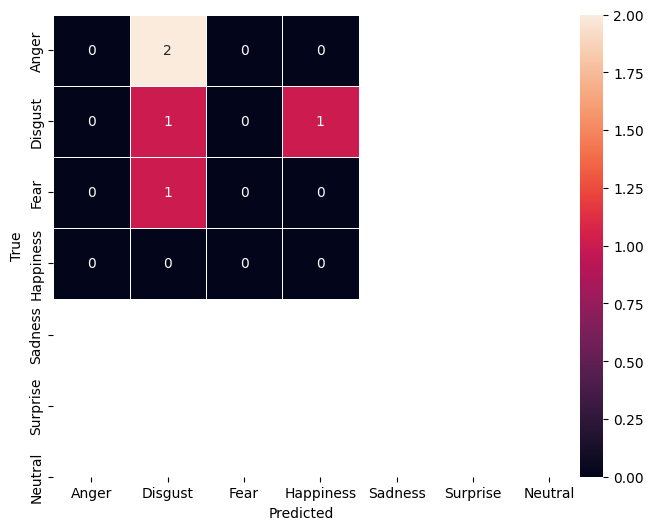

In [ ]:
# The results on the test set as confusion matrix
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

cm = confusion_matrix(y_true, y_pred)

# plot with seaborn
fig, ax = plt.subplots(figsize=(8,6))  
ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, xticklabels=string_labels, yticklabels=string_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Saving metrics and artifacts in MLflow

In [ ]:
# Generate a unique model filename based on the run name
model_filename = f"Model_{run_name}"
experiment_id = mlflow.active_run().info.experiment_id
run_id = mlflow.active_run().info.run_id

print('Model filename: ' + model_filename)
print('Experiment id: ' + experiment_id)
print('Run id: ' + run_id)

'Model_fuxking_one_more'

In [ ]:
model.save_pretrained(f"/content/gdrive/MyDrive/Semester_Project/mlruns/{experiment_id}/{run_id}/artifacts/{model_filename}")

In [ ]:
# Generate a unique model filename based on the run ID
preprocessed_train_ds_filename = f"Preprocessed_train_ds_{run_name}"
preprocessed_val_ds_filename = f"Preprocessed_val_ds{run_name}"
preprocessed_test_ds_filename = f"Preprocessed_test_ds_{run_name}"

mlflow.log_artifact(local_path="/content/gdrive/MyDrive/Semester_Project/preprocessed_train_ds.pickle", artifact_path=preprocessed_train_ds_filename)
mlflow.log_artifact(local_path="/content/gdrive/MyDrive/Semester_Project/preprocessed_val_ds.pickle", artifact_path=preprocessed_val_ds_filename)
mlflow.log_artifact(local_path="/content/gdrive/MyDrive/Semester_Project/preprocessed_test_ds.pickle", artifact_path=preprocessed_test_ds_filename)

In [ ]:
# Extracting test metrics
test_loss = outputs.metrics['test_loss']
test_accuracy = outputs.metrics['test_accuracy']
test_runtime = outputs.metrics['test_runtime']
test_samples_per_second = outputs.metrics['test_samples_per_second']
test_steps_per_second = outputs.metrics['test_steps_per_second']

In [ ]:
# Saving test metrics
mlflow.log_metric("test_loss", test_loss)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_runtime", test_runtime)
mlflow.log_metric("test_samples_per_second", test_samples_per_second)
mlflow.log_metric("test_steps_per_second", test_steps_per_second)

In [ ]:
mlflow.end_run()

## EDA

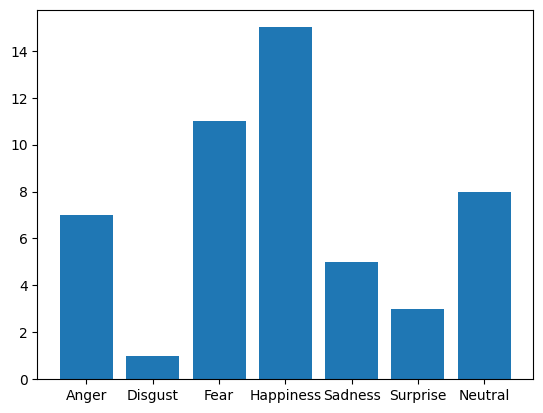

In [ ]:
# distribution of labels in the training set
keys, counts = np.unique(preprocessed_train_ds["label"], return_counts=True)
plt.bar(string_labels, counts)
plt.show()

In [ ]:
# distribution of labels in the training set
fer_train_df = fer_df[fer_df['Usage']=='Training']
keys, counts = np.unique(fer_train_df["label"], return_counts=True)
plt.bar(string_labels, counts)
plt.show()